# 0. SKA continuum image classification using convolutional neural networks

In this notebook, we attempt to classify simulated SKA continuum image using convolutional neural networks.


The data is a simulated SKA continuum image in total intensity of the same field at 560 MHz, representative of SKA Mid Band 1 and a 8 hour telescope integration, representative of a single. More details can be found in the [SKA SCIENCE DATA CHALLENGE 1](https://astronomers.skatelescope.org/wp-content/uploads/2018/11/SKA-TEL-SKO-0001001-SKA_DataChallengesDataDescription-signed.pdf). 


The aim of this work is to train a neural network to classify active galactic nucles (AGNs) and star forming galaxies (SFGs).


In [1]:
# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization

# check version
print('Using TensorFlow v%s' % tf.__version__)
acc_str = 'accuracy' if tf.__version__[:2] == '2.' else 'acc'

# helpers
import h5py
import numpy as np
import matplotlib.pyplot as plt
from os.path import join

# need some certainty in data processing
np.random.seed(1234)
tf.random.set_seed(1234)

data_path = 'data'

Using TensorFlow v2.7.0


## Google Cloud Storage Boilerplate

The following two cells have some boilerplate to mount the Google Cloud Storage bucket containing the data used for this notebook to your Google Colab file system. **Even you are not using Google Colab, please make sure you run these two cells.** 

To access the data from Google Colab, you need to:

1. Run the first cell;
2. Follow the link when prompted (you may be asked to log in with your Google account);
3. Copy the Google SDK token back into the prompt and press `Enter`;
4. Run the second cell and wait until the data folder appears.

If everything works correctly, a new folder called `sciml-workshop-data` should appear in the file browser on the left. Depending on the network speed, this may take one or two minutes. Ignore the warning "You do not appear to have access to project ...". If you are running the notebook locally or you have already connected to the bucket, these cells will have no side effects.

In [2]:
# variables passed to bash; do not change
project_id = 'sciml-workshop'
bucket_name = 'sciml-workshop'
colab_data_path = '/content/sciml-workshop-data/'

try:
    from google.colab import auth
    auth.authenticate_user()
    google_colab_env = 'true'
    data_path = colab_data_path
except:
    google_colab_env = 'false'
    ###################################################
    ######## specify your local data path here ########
    ###################################################
    with open('../local_data_path.txt', 'r') as f: data_path = f.read().splitlines()[0]

In [3]:
%%bash -s {google_colab_env} {colab_data_path} {project_id} {bucket_name}

# running locally
if ! $1; then
    echo "Running notebook locally."
    exit
fi

# already mounted
if [ -d $2 ]; then
    echo "Data already mounted."
    exit
fi

# mount the bucket
echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
apt -qq update
apt -qq install gcsfuse
gcloud config set project $3
mkdir $2
gcsfuse --implicit-dirs --limit-bytes-per-sec -1 --limit-ops-per-sec -1 $4 $2

Running notebook locally.


---

# 1. Load the dataset

### Read raw data

We have already split the data into training and validation sets and saved them into two HDF5 files, `Astronomy/scd2d_13_train.h5` and `Astronomy/scd2d_13_test.h5`, containing respectively 80% and 20% of images and their one-hot encoded labels identifying an image as either being of the *AGNs* or *SFGs*. 


**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
with h5py.File(join(data_path, 'Astronomy/scd2d_64_train.h5'), 'r') as F:
    x_train = np.array(F['images'])
    y_train = np.array(F['labels'])            
            
with h5py.File(join(data_path, 'Astronomy/scd2d_64_test.h5'), 'r') as F:
    x_test = np.array(F['images'])
    y_test = np.array(F['labels'])
```
    
</p>
</details>

In [4]:
with h5py.File(join(data_path, 'Astronomy/scd2d_64_train.h5'), 'r') as F:
    x_train = np.array(F['images'])
    y_train = np.array(F['labels'])            
            
with h5py.File(join(data_path, 'Astronomy/scd2d_64_test.h5'), 'r') as F:
    x_test = np.array(F['images'])
    y_test = np.array(F['labels'])

In [5]:
# define image size
IMG_HEIGHT = 64
IMG_WIDTH = 64
N_CHANNELS = 1
N_CLASSES = 2
    
# string labels
string_labels = ['AGNs', 'SFGs']

# print
print("Number of training data: %d" % len(x_train))
print("Number of test data: %d" % len(x_test))
print("Image pixels: %s" % str(x_train[0, :, :, 0].shape))
print("Number of channels: %s" % str(x_train.shape[-1]))

Number of training data: 10261
Number of test data: 2577
Image pixels: (64, 64)
Number of channels: 1


### Load and use data

In the following cell, we will load the first buffer (with 32 data by default) to memory and plot some images and labels from it:

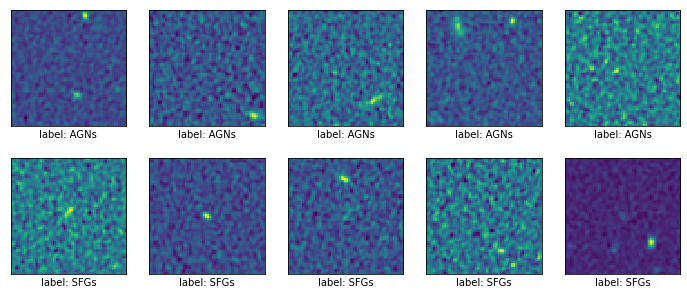

In [6]:
# plot some images and labels from it
fig, axes = plt.subplots(N_CLASSES, 5, figsize=(12, 5))
for i in range(N_CLASSES):
    y_sub = np.random.choice(np.where(y_train == i)[0], 5)
    for j in range(5):
        axes[i][j].matshow(np.squeeze(x_train[y_sub[j]]))
        axes[i][j].set_xlabel('label: ' + string_labels[i])
        axes[i][j].set_xticks([])
        axes[i][j].set_yticks([])
        

---

# 2. Build the network

In this case, we have binary classification. We can deal with binary classification by outputing 1 value and using 'binary_crossentropy'.



**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
# network architecture
model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5), strides = 2, activation='relu', padding='same',
                 input_shape=(IMG_HEIGHT, IMG_WIDTH, N_CHANNELS)))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3, 3), strides = 2, activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(1, activation = "sigmoid"))  

# print summary
model.summary()
```
    
</p>
</details>


In [7]:
# network architecture
model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5), strides = 2, activation='relu', padding='same',
                 input_shape=(IMG_HEIGHT, IMG_WIDTH, N_CHANNELS)))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3, 3), strides = 2, activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(1, activation = "sigmoid"))  

# print summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 64)         0         
 2D)                                                             
                                                        

2022-03-28 11:17:23.334837: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-28 11:17:23.896797: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14773 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:3b:00.0, compute capability: 7.5


### metrics

We can add the following metrics to see how the network performs for the two classes:

* `TruePositives`: number of right predictions for AGNs
* `FalsePositives`: number of wrong predictions for AGNs
* `TrueNegatives`: number of right predictions for SFGs
* `FalseNegatives`: number of wrong predictions for SFGs

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
# compile the model
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt, loss="binary_crossentropy", 
              metrics= ['accuracy',
                        keras.metrics.TruePositives(name='true_positives'),
                        keras.metrics.FalsePositives(name='false_positives'),
                        keras.metrics.TrueNegatives(name='true_negatives'),
                        keras.metrics.FalseNegatives(name='false_negatives')])
```
    
</p>
</details>


In [8]:
# compile the model
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt, loss="binary_crossentropy", 
              metrics= ['accuracy',
                        keras.metrics.TruePositives(name='true_positives'),
                        keras.metrics.FalsePositives(name='false_positives'),
                        keras.metrics.TrueNegatives(name='true_negatives'),
                        keras.metrics.FalseNegatives(name='false_negatives')])

### Train the model

Using the suggested architecture, we can achieve an accuracy greater than 95% with 2 epochs. 

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
# train the model
training_history = model.fit(x_train, y_train, validation_data=(x_test, y_test), 
                             epochs=20, batch_size=64)

# print final values of metrics for validation data
print('Right for AGNs: %d' % training_history.history['val_true_positives'][-1])
print('Wrong for AGNs: %d' % training_history.history['val_false_positives'][-1])
print('Right for SFGs: %d' % training_history.history['val_true_negatives'][-1])
print('Wrong for SFGs: %d' % training_history.history['val_false_negatives'][-1])
```
    
</p>
</details>

In [9]:
# train the model
training_history = model.fit(x_train, y_train, validation_data=(x_test, y_test), 
                             epochs=20, batch_size=64)

# print final values of metrics for validation data
print('Right for AGNs: %d' % training_history.history['val_true_positives'][-1])
print('Wrong for AGNs: %d' % training_history.history['val_false_positives'][-1])
print('Right for SFGs: %d' % training_history.history['val_true_negatives'][-1])
print('Wrong for SFGs: %d' % training_history.history['val_false_negatives'][-1])

Epoch 1/20


2022-03-28 11:17:25.593078: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201
2022-03-28 11:17:26.059759: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-03-28 11:17:26.060569: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-03-28 11:17:26.060583: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-03-28 11:17:26.061159: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-03-28 11:17:26.061209: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


161/161 [==============================] - 4s 11ms/step - loss: 0.6595 - accuracy: 0.6683 - true_positives: 3217.0000 - false_positives: 1412.0000 - true_negatives: 3640.0000 - false_negatives: 1992.0000 - val_loss: 0.5928 - val_accuracy: 0.7031 - val_true_positives: 595.0000 - val_false_positives: 70.0000 - val_true_negatives: 1217.0000 - val_false_negatives: 695.0000
Epoch 2/20
161/161 [==============================] - 1s 8ms/step - loss: 0.5578 - accuracy: 0.7253 - true_positives: 3414.0000 - false_positives: 1024.0000 - true_negatives: 4028.0000 - false_negatives: 1795.0000 - val_loss: 0.6326 - val_accuracy: 0.7113 - val_true_positives: 725.0000 - val_false_positives: 179.0000 - val_true_negatives: 1108.0000 - val_false_negatives: 565.0000
Epoch 3/20
161/161 [==============================] - 1s 8ms/step - loss: 0.5284 - accuracy: 0.7428 - true_positives: 3534.0000 - false_positives: 964.0000 - true_negatives: 4088.0000 - false_negatives: 1675.0000 - val_loss: 0.5199 - val_accurac

---

# 3. Analyse results 

### Plot training history

For convenience, we define a function to plot a training history:

In [10]:
# a function to plot training history
def plot_history(training_history):
    # plot accuracy
    plt.figure(dpi=100, figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(training_history.history[acc_str], label='Accuracy on training data')
    plt.plot(training_history.history['val_' + acc_str], label='Accuracy on test data')
    plt.legend()
    plt.title("Accuracy")

    # plot loss
    plt.subplot(1, 2, 2)
    plt.plot(training_history.history['loss'], label='Loss on training data')
    plt.plot(training_history.history['val_loss'], label='Loss on test data')
    plt.legend()
    plt.title("Loss")
    plt.show()

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
# plot training history
plot_history(training_history)
```
    
</p>
</details>

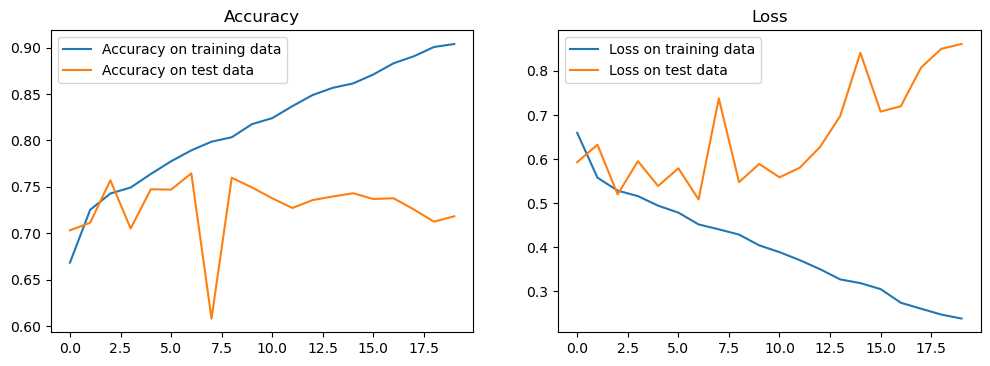

In [11]:
# plot training history
plot_history(training_history)

---

# 4. Exercises

* Change some hyperparameters in `model.compile()` and `model.fit()` to see their effects (see reference of [tf.keras.Model](https://www.tensorflow.org/api_docs/python/tf/keras/Model)); 
* Change the architeture and activation functions of neural networks to improve the accuracy